In [1]:
from generate_chunks import load_data
from train_models import ModelTrainer
from failure_detection import detect_failures, failure_list_to_interval, print_failures, collate_intervals, extreme_anomaly, simple_lowpass_filter
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

train_chunks, training_chunk_dates, test_chunks, test_chunk_dates = load_data(version=3)


In [14]:
model = ModelTrainer('configs/PT3_WAE_NOGAN.json').fit()

train_errors = model.calc_loss(train_chunks, train_chunks, average=False).mean(axis=(1,2))
test_errors = model.calc_loss(test_chunks, test_chunks, average=False).mean(axis=(1,2))


Detected failures
[2020-04-06 11:52:19, 2020-04-06 15:16:18]
[2020-04-12 13:13:08, 2020-04-13 00:37:07]
[2020-04-18 01:43:36, 2020-04-19 04:11:20]
[2020-05-13 14:52:08, 2020-05-14 05:54:39]
[2020-05-19 06:09:45, 2020-05-21 06:36:53]
[2020-05-30 00:27:27, 2020-05-30 07:08:57]
[2020-06-02 19:47:58, 2020-06-02 21:33:41]
[2020-06-05 10:57:24, 2020-06-08 15:14:57]
[2020-07-08 18:44:55, 2020-07-08 22:18:01]
[2020-07-14 02:55:17, 2020-07-17 08:09:23]
[2020-07-31 06:18:34, 2020-07-31 06:28:28]
Actual failures
2020-04-18T00:00:00 2020-04-18T23:59:00
2020-05-29T23:30:00 2020-05-30T06:00:00
2020-06-05T10:00:00 2020-06-07T14:30:00
2020-07-15T14:30:00 2020-07-15T19:00:00


(18353.0, 18475.0)

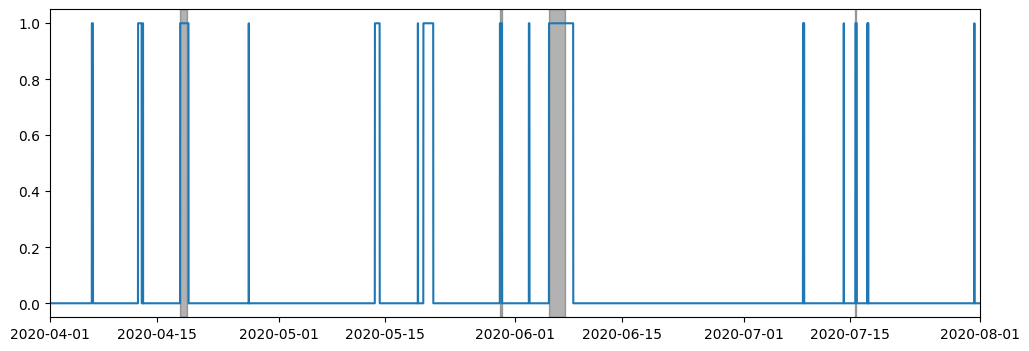

In [15]:
anom = extreme_anomaly(train_errors)
binary_output = (test_errors > anom).astype(np.int8)

output = simple_lowpass_filter(binary_output, 0.06)
failures = (output >= 0.5).astype(np.int8)

print('Detected failures')
print_failures(test_chunk_dates, failures)
print('Actual failures')
actual_failures = [
    (np.datetime64('2020-04-18T00:00:00'), np.datetime64('2020-04-18T23:59:00')),
    (np.datetime64('2020-05-29T23:30:00'), np.datetime64('2020-05-30T06:00:00')),
    (np.datetime64('2020-06-05T10:00:00'), np.datetime64('2020-06-07T14:30:00')),
    (np.datetime64('2020-07-15T14:30:00'), np.datetime64('2020-07-15T19:00:00')),
]
plt.figure(figsize=(12, 4))
plt.plot(test_chunk_dates[:, 1], failures)
for (start, end) in actual_failures:
    print(start, end)
    plt.axvspan(start, end, color='black', alpha=0.3)

plt.xlim(test_chunk_dates[0][0], np.datetime64('2020-08-01T00:00:00'))

# Are the decision rules from PT2 transferable?

In [9]:
import pickle
import numpy as np

oil_temperate_idx = 5
motor_current_idx = 6

with open('data/pt3_train_chunks_unnormalized.pkl', 'rb') as f:
    x_raw = pickle.load(f)
x_raw = x_raw[..., [oil_temperate_idx, motor_current_idx]]

# Transform features
min_current = x_raw[..., 1].min(axis=-1)
max_temperature = x_raw[..., 0].max(axis=-1)

# Apply rules
current_thresh = 0.014
#tempreature_thresh = 73.487
tempreature_thresh = 79
failures = (min_current <= current_thresh).astype(np.int8)
print('after first rule', np.unique(failures, return_counts=True))
failures += np.logical_and(min_current > current_thresh, max_temperature > tempreature_thresh).astype(np.int8)
print('after all rules', np.unique(failures, return_counts=True))
# print(failures.shape)
# print(np.unique(failures, return_counts=True))
# print_failures(test_chunk_dates, failures)
# print('Actual failures')
# print('2020-04-18 00:00:00, 2020-04-18 23:59:00')
# print('2020-05-29 23:30:00, 2020-05-30 06:00:00')
# print('2020-06-05 10:00:00, 2020-06-07 14:30:00')
# print('2020-07-15 14:30:00, 2020-07-15 19:00:00')


after first rule (array([0], dtype=int8), array([72226]))
after all rules (array([0, 1], dtype=int8), array([71775,   451]))
